# Stokes Wave Approximation Tools

This module provides functions to compute the properties of Stokes waves in deep water. The Stokes expansion is a perturbation technique that approximates nonlinear wave profiles and frequencies. The functions in this module enable evaluation of surface elevations, dispersion relations, and parameter validation for wave steepness limits.

**Contents:**
- **get_max_valid_order**: Returns the highest expansion order currently supported.
- **stokes_coefficient**: Computes the nth-order Stokes coefficient, based on a factorial-based formula.
- **stokes_standing_wave**: Evaluates surface elevations of a standing Stokes wave at given positions and times, up to a specified order.
- **dispersion_relation**: Computes wave frequency corrections using nonlinear dispersion relations, for orders up to the validated maximum.
- **validate_stokes_parameters**: Checks the chosen wave parameters for validity, warning if the steepness is likely too high for a reliable Stokes expansion.

**Usage notes:**
- The implementation is valid for deep water waves only
- Ensure that chosen orders do not exceed the maximum supported order for calculation of $\omega$, initial shape is fine.
- For nonlinear dispersion corrections, the wave amplitude is required.
- Consider validating parameters before running higher-order computations, as large steepness can reduce convergence accuracy if you want to further construct a standing wave temporal solution with $(kx-\omega*t)$.

In [6]:
import numpy as np
import math

def get_max_valid_order():
    """Return the maximum order for which we have valid dispersion coefficients."""
    return 8  # Currently we have coefficients up to 8th order

def stokes_coefficient(n):
    """
    Calculate the nth order Stokes coefficient for deep water waves.
    """
    if n == 1:
        return 1.0
    # Calculate double factorial of (2n-1)
    k = 2 * n - 1
    double_factorial = np.prod(np.arange(1, k + 1, 2))
    return double_factorial / (2**(n-1) * math.factorial(n))

def stokes_standing_wave(x, t, a, k, order=5):
    """
    Calculate the Stokes standing wave surface elevation.
    
    Raises:
    -------
    Warning if requested order exceeds maximum valid order.
    """
    if order < 1:
        raise ValueError("Order must be at least 1")
    
    # Initialize surface elevation
    eta = np.zeros_like(x, dtype=float)
    
    # Wave steepness
    epsilon = k * a
    
    # Compute contributions for each order with corrected coefficients
    for n in range(1, order + 1):
        coeff = stokes_coefficient(n)
        eta += coeff * epsilon**n * np.cos(n*k*x)

    return eta * a


def dispersion_relation(k, g=9.81, order=5, a=0.1):
    """
    Compute the deep-water wave frequency up to '8th order' in the classical Stokes sense.
    
    Parameters
    ----------
    k : float
        Wavenumber (2*pi / wavelength)
    a : float
        Wave amplitude
    g : float, optional
        Gravitational acceleration (default 9.81 m/s^2)
    order : int, optional
        Highest power of epsilon^2 to include (must be 0, 2, 4, 6, or 8).
        Default is 8 (i.e., terms up to epsilon^8).

    Returns
    -------
    omega : float
        Nonlinear wave frequency including up to 'order' in the expansion.
    
    Notes
    -----
    1) Valid for deep water and small-to-moderate steepness epsilon = k*a < ~0.44.
    2) 'order' here refers to the highest exponent of epsilon in the classical expansions, 
       which come in even powers: 0,2,4,6,8,...
    3) The polynomial coefficients below match 
         omega / sqrt(g k) = 1 + 1/2 * eps^2 + 3/8 * eps^4 + 5/16 * eps^6 + 35/128 * eps^8 + ...
       from standard Stokes theory references.
    """
    if order is 1:
        return np.sqrt(g * k)
    # Ensure order is one of the recognized even exponents: 0, 2, 4, 6, 8
    if order not in [0, 2, 4, 6, 8]:
        raise ValueError("order must be one of [0, 2, 4, 6, 8] for the classical expansions.")

    # Define the known expansion coefficients for omega/omega_0
    # Key = exponent of epsilon, Value = coefficient
    stokes_expansion = {
        0: 1.0,        # 1
        2: 4e0/3.0,        # 1/2
        4: 3.0/8.0,    # 0.375
        6: 17.0/9.0,   # 0.3125
        8: -22.0/9.0  # 0.2734375
    }

    # Wave steepness
    epsilon = k * a
    # Base (linear) frequency
    omega_0 = np.sqrt(g * k)

    # Sum up expansion terms up to the chosen order
    freq_factor = 0.0
    for exp in [0, 2, 4, 6, 8]:
        if exp <= order:
            freq_factor += stokes_expansion[exp] * (epsilon**exp)

    # Multiply by the linear frequency
    omega = omega_0 * freq_factor
    return omega

def validate_stokes_parameters(k, a):
    """
    Validate the parameters for Stokes wave theory.
    
    Parameters:
    -----------
    k : float
        Wavenumber
    a : float
        Wave amplitude
        
    Returns:
    --------
    bool
        True if parameters are valid, False otherwise
    """
    epsilon = k * a
    if epsilon > 0.44:
        print(f"Warning: Wave steepness ka = {epsilon:.3f} > 0.44")
        print("Stokes expansion may not converge")
        return False
        
    return True

<>:74: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:74: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/hg/m418rn8d5xnb7c4stqrfb1w40000gn/T/ipykernel_72544/2563164704.py:74: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if order is 1:


# Stokes Wave Initial Condition Comparison Plot

This code generates a comparison plot between experimental/numerical data points and theoretical Stokes standing wave profiles for different orders. The plot demonstrates how increasing the order of the Stokes expansion affects the wave profile prediction.

## Plot Components

1. **Experimental/Numerical Data**
   - Black dots with connecting lines represent the input data points (manually extracted from experimental data)
   ![experimental image](initialCondition.png)
   - Data is shifted to align with theoretical predictions starting point

2. **Theoretical Stokes Waves**
   - Multiple Stokes wave profiles from order 1 to 10 are plotted
   - Uses a coolwarm colormap to distinguish between different orders
   - Each profile is calculated using:
     - Amplitude (a) = 0.10
     - Wavenumber (k) = 2π
     - Time (t) = 0 (initial condition)

## Implementation Details

- The x-axis spans from -0.5 to 0.5 with 1000 points for smooth theoretical curves
- Wave parameters are validated using `validate_stokes_parameters()`
- Dispersion relation is calculated for each order using `dispersion_relation()`
- Surface elevation is computed using `stokes_standing_wave()`
- All profiles are zeroed at their starting point for consistent comparison

## Plot Features

- Figure size: 10x6 inches
- Grid: Dashed lines with 0.7 alpha transparency
- Legend: Shows the order of each Stokes wave profile
- Axes are labeled as 'x' and 'y'

# Stokes Wave Initial Condition Comparison Plot

This code generates a comparison plot between experimental/numerical data points and theoretical Stokes standing wave profiles for different orders. The plot demonstrates how increasing the order of the Stokes expansion affects the wave profile prediction.

## Plot Components

1. **Experimental/Numerical Data**
   - Black dots with connecting lines represent the input data points
   - Data is shifted to align with theoretical predictions starting point

2. **Theoretical Stokes Waves**
   - Multiple Stokes wave profiles from order 1 to 10 are plotted
   - Uses a coolwarm colormap to distinguish between different orders
   - Each profile is calculated using:
     - Amplitude (a) = 0.10
     - Wavenumber (k) = 2π
     - Time (t) = 0 (initial condition)

## Implementation Details

- The x-axis spans from -0.5 to 0.5 with 1000 points for smooth theoretical curves
- Wave parameters are validated using `validate_stokes_parameters()`
- Dispersion relation is calculated for each order using `dispersion_relation()`
- Surface elevation is computed using `stokes_standing_wave()`
- All profiles are zeroed at their starting point for consistent comparison

## Plot Features

- Figure size: 10x6 inches
- Grid: Dashed lines with 0.7 alpha transparency
- Legend: Shows the order of each Stokes wave profile
- Axes are labeled as 'x' and 'y'

Stokes expansion may not converge
Proceeding anyways, as this is only the initial condition
omega =  7.850990247314777
omega =  11.98358586853118
omega =  12.442440562755829
omega =  13.354892631056417
omega =  12.888723452515672


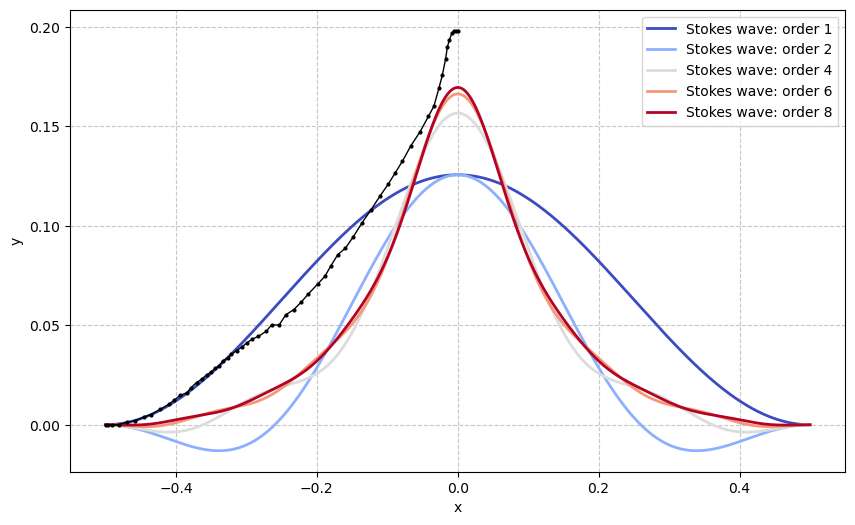

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Data points
x = [0, 0.0035714285714285713, 0.008928571428571428, 0.01845238095238095,
     0.030357142857142857, 0.04166666666666667, 0.05416666666666667, 0.06488095238095239,
     0.07738095238095238, 0.0898809523809524, 0.09702380952380953, 0.10595238095238095,
     0.11547619047619048, 0.12142857142857143, 0.12916666666666668, 0.13749999999999998,
     0.14345238095238097, 0.14940476190476193, 0.15535714285714286, 0.16130952380952382,
     0.16666666666666669, 0.17321428571428574, 0.17857142857142858, 0.1863095238095238,
     0.19404761904761905, 0.2005952380952381, 0.20833333333333334, 0.21666666666666667,
     0.22797619047619047, 0.23571428571428574, 0.24642857142857144, 0.255952380952381,
     0.26726190476190476, 0.2779761904761905, 0.28750000000000003, 0.30119047619047623,
     0.3113095238095238, 0.3196428571428572, 0.32976190476190476, 0.3404761904761905,
     0.35178571428571426, 0.36428571428571427, 0.3767857142857143, 0.3898809523809524,
     0.4011904761904762, 0.4113095238095238, 0.42142857142857143, 0.43333333333333335,
     0.44642857142857145, 0.4583333333333333, 0.46607142857142864, 0.4732142857142857,
     0.4779761904761905, 0.48273809523809524, 0.4851190476190476, 0.48809523809523814,
     0.4916666666666667, 0.49464285714285716, 0.4976190476190476, 0.5]

y = [0, 0, 0, 0,
     0.0012861736334405238, 0.001929260450160758, 0.003858520900321516, 0.00514469453376204,
     0.007717041800643087, 0.010289389067524135, 0.012218649517684893, 0.014790996784565913,
     0.01607717041800641, 0.018649517684887457, 0.021221864951768504, 0.023151125401929262,
     0.02508038585209002, 0.026366559485530544, 0.028295819935691302, 0.029581993569131826,
     0.032154340836012846, 0.03344051446945337, 0.035369774919614155, 0.03729903536977491,
     0.0392282958199357, 0.04115755627009646, 0.043086816720257215, 0.04437299035369774,
     0.046945337620578786, 0.05016077170418007, 0.05016077170418007, 0.05530546623794211,
     0.057877813504823156, 0.06173633440514467, 0.06559485530546624, 0.07073954983922828,
     0.07459807073954985, 0.0797427652733119, 0.0855305466237942, 0.08874598070739548,
     0.09453376205787781, 0.10160771704180063, 0.1080385852090032, 0.11511254019292602,
     0.12090032154340835, 0.12668810289389065, 0.13247588424437298, 0.14019292604501604,
     0.14726688102893887, 0.15498392282958195, 0.16012861736334405, 0.16913183279742763,
     0.1755627009646302, 0.18392282958199355, 0.18971061093247588, 0.1935691318327974,
     0.1967845659163987, 0.1980707395498392, 0.1980707395498392, 0.1980707395498392]

# Create the plot
plt.figure(figsize=(10, 6))

## theory stuff
EtaX = np.linspace(-0.5, 0.5, 1000)
a = 0.10  # amplitude (adjust this value)
k = 2*np.pi  # wave number (adjust this value)

if validate_stokes_parameters(k,a) is not True:
     print("Proceeding anyways, as this is only the initial condition")

OrderToPlot = [1,2,4,6,8]
# Create a color list from the colormap
COLORS = plt.cm.coolwarm(np.linspace(0, 1, len(OrderToPlot)))  # 3 colors for 3 orders

count = 0
for n in OrderToPlot:
     omega = dispersion_relation(k, g=9.81, order=n, a=a)
     if omega is not None:
          print("omega = ", omega)
     etaY = stokes_standing_wave(EtaX, 0., a, k, order=n)
     etaY = etaY - etaY[0]
     plt.plot(EtaX, etaY, '-', color=COLORS[count], linewidth=2, label=f'Stokes wave: order {n}')
     count += 1


x = np.array(x, dtype=float)
y = np.array(y, dtype=float)

x = x-x[0]+EtaX[0]
y = y-y[0]

plt.plot(x, y, 'k.-', linewidth=1, markersize=4)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Show the plot
plt.show()

# Stokes Wave Initial Condition Comparison Plot (Normalized and Symmetric)

This code generates a comparison plot between experimental data points and theoretical Stokes standing wave profiles, with several improvements over the previous version:

## Key Changes from Previous Version

1. **Amplitude Normalization**
   - Theoretical profiles are now normalized by their maximum amplitude
   - Each profile is scaled to match twice the input amplitude (2*a)
   - Formula: etaY = etaY/np.max(etaY)*(2*a)

2. **Symmetric Plotting**
   - Experimental data is now plotted symmetrically
   - Original data plotted as is (positive x)
   - Mirrored data added (negative x)
   - Both sides labeled to distinguish experimental data in legend

## Plot Components

1. **Experimental Data**
   - Black dots with connecting lines
   - Shown on both positive and negative x-axis
   - Labeled as 'Exp' in legend (only positive side shown in legend)

2. **Theoretical Stokes Waves**
   - Multiple Stokes wave profiles from order 1 to 10
   - Uses coolwarm colormap for different orders
   - Parameters:
     - Amplitude (a) = 0.10
     - Wavenumber (k) = 2π
     - Time (t) = 0 (initial condition)

## Implementation Details

- X-axis range: [-0.5, 0.5] with 1000 points
- Wave parameters validated using `validate_stokes_parameters()`
- Dispersion relation calculated for each order
- All profiles zeroed at their starting point
- Normalized to match experimental amplitude

## Plot Features

- Figure size: 10x6 inches
- Grid: Dashed lines with 0.7 alpha transparency
- Legend: Shows order of each Stokes wave profile and experimental data
- Axes labeled as 'x' and 'y'

Stokes expansion may not converge
Proceeding anyways, as this is only the initial condition
omega =  7.850990247314777
omega =  11.98358586853118
omega =  12.442440562755829
omega =  13.354892631056417
omega =  12.888723452515672


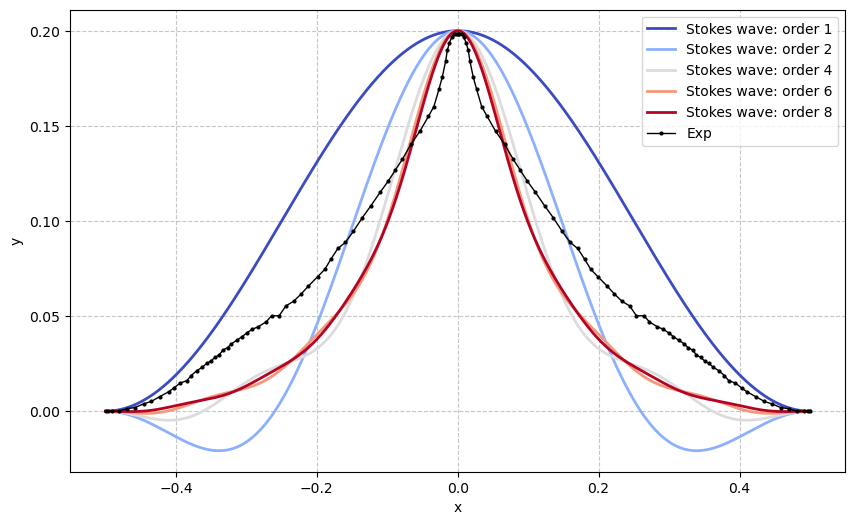

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Data points
x = [0, 0.0035714285714285713, 0.008928571428571428, 0.01845238095238095,
     0.030357142857142857, 0.04166666666666667, 0.05416666666666667, 0.06488095238095239,
     0.07738095238095238, 0.0898809523809524, 0.09702380952380953, 0.10595238095238095,
     0.11547619047619048, 0.12142857142857143, 0.12916666666666668, 0.13749999999999998,
     0.14345238095238097, 0.14940476190476193, 0.15535714285714286, 0.16130952380952382,
     0.16666666666666669, 0.17321428571428574, 0.17857142857142858, 0.1863095238095238,
     0.19404761904761905, 0.2005952380952381, 0.20833333333333334, 0.21666666666666667,
     0.22797619047619047, 0.23571428571428574, 0.24642857142857144, 0.255952380952381,
     0.26726190476190476, 0.2779761904761905, 0.28750000000000003, 0.30119047619047623,
     0.3113095238095238, 0.3196428571428572, 0.32976190476190476, 0.3404761904761905,
     0.35178571428571426, 0.36428571428571427, 0.3767857142857143, 0.3898809523809524,
     0.4011904761904762, 0.4113095238095238, 0.42142857142857143, 0.43333333333333335,
     0.44642857142857145, 0.4583333333333333, 0.46607142857142864, 0.4732142857142857,
     0.4779761904761905, 0.48273809523809524, 0.4851190476190476, 0.48809523809523814,
     0.4916666666666667, 0.49464285714285716, 0.4976190476190476, 0.5]

y = [0, 0, 0, 0,
     0.0012861736334405238, 0.001929260450160758, 0.003858520900321516, 0.00514469453376204,
     0.007717041800643087, 0.010289389067524135, 0.012218649517684893, 0.014790996784565913,
     0.01607717041800641, 0.018649517684887457, 0.021221864951768504, 0.023151125401929262,
     0.02508038585209002, 0.026366559485530544, 0.028295819935691302, 0.029581993569131826,
     0.032154340836012846, 0.03344051446945337, 0.035369774919614155, 0.03729903536977491,
     0.0392282958199357, 0.04115755627009646, 0.043086816720257215, 0.04437299035369774,
     0.046945337620578786, 0.05016077170418007, 0.05016077170418007, 0.05530546623794211,
     0.057877813504823156, 0.06173633440514467, 0.06559485530546624, 0.07073954983922828,
     0.07459807073954985, 0.0797427652733119, 0.0855305466237942, 0.08874598070739548,
     0.09453376205787781, 0.10160771704180063, 0.1080385852090032, 0.11511254019292602,
     0.12090032154340835, 0.12668810289389065, 0.13247588424437298, 0.14019292604501604,
     0.14726688102893887, 0.15498392282958195, 0.16012861736334405, 0.16913183279742763,
     0.1755627009646302, 0.18392282958199355, 0.18971061093247588, 0.1935691318327974,
     0.1967845659163987, 0.1980707395498392, 0.1980707395498392, 0.1980707395498392]

# Create the plot
plt.figure(figsize=(10, 6))

## theory stuff
EtaX = np.linspace(-0.5, 0.5, 1000)
a = 0.10  # amplitude (adjust this value)
k = 2*np.pi  # wave number (adjust this value)

if validate_stokes_parameters(k,a) is not True:
     print("Proceeding anyways, as this is only the initial condition")

OrderToPlot = [1,2,4,6,8]
# Create a color list from the colormap
COLORS = plt.cm.coolwarm(np.linspace(0, 1, len(OrderToPlot)))  # 3 colors for 3 orders

count = 0
for n in OrderToPlot:
     omega = dispersion_relation(k, g=9.81, order=n, a=a)
     if omega is not None:
          print("omega = ", omega)
     etaY = stokes_standing_wave(EtaX, 0., a, k, order=n)
     etaY = etaY - etaY[0]
     etaY = etaY/np.max(etaY)*(2*a)
     plt.plot(EtaX, etaY, '-', color=COLORS[count], linewidth=2, label=f'Stokes wave: order {n}')
     count += 1


x = np.array(x, dtype=float)
y = np.array(y, dtype=float)

x = x-x[0]+EtaX[0]
y = y-y[0]
plt.plot(x, y, 'k.-', linewidth=1, markersize=4, label='Exp')
plt.plot(-x, y, 'k.-', linewidth=1, markersize=4, label='_Exp')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Show the plot
plt.show()

# Enhanced Standing Wave Analysis with Optimization

This code performs an advanced analysis of standing waves, comparing experimental data with theoretical Stokes wave solutions. Key features include:

1. **Data Processing**
   - Converts experimental data points to numpy arrays
   - Creates a symmetric wave profile by mirroring and concatenating the data
   - Ensures data continuity through proper sorting of x-coordinates

2. **Theoretical Analysis**
   - Generates Stokes wave solutions for orders 1 and 10
   - Normalizes wave amplitudes for consistent comparison
   - Interpolates theoretical solutions to match experimental x-coordinates

3. **Optimization**
   - Implements least squares optimization to find optimal weight between order 1 and order 10 solutions
   - Minimizes the sum of squared differences between experimental and theoretical data
   - Automatically determines the best combination of different order solutions

4. **Visualization**
   - Plots experimental data points
   - Shows theoretical solutions for different orders
   - Displays the optimized fit combining multiple orders
   - Includes grid, labels, and legend for clarity

The optimization routine finds the weight `wt_best` that minimizes the difference between the experimental data and a weighted combination of order 1 and order 10 Stokes waves, providing insight into the nonlinear nature of the observed wave pattern.

Stokes expansion may not converge
Proceeding anyways, as this is only the initial condition
omega =  7.850990247314777
omega =  13.354892631056417
Best wt: 0.34749786297039387


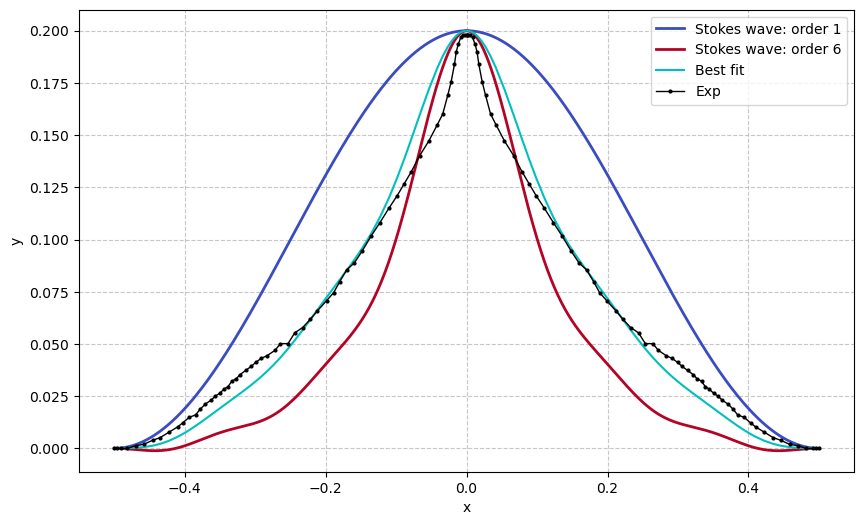

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load the uploaded image
image_path = 'initialCondition.png'
image = Image.open(image_path)

# Data points
x = [0, 0.0035714285714285713, 0.008928571428571428, 0.01845238095238095,
     0.030357142857142857, 0.04166666666666667, 0.05416666666666667, 0.06488095238095239,
     0.07738095238095238, 0.0898809523809524, 0.09702380952380953, 0.10595238095238095,
     0.11547619047619048, 0.12142857142857143, 0.12916666666666668, 0.13749999999999998,
     0.14345238095238097, 0.14940476190476193, 0.15535714285714286, 0.16130952380952382,
     0.16666666666666669, 0.17321428571428574, 0.17857142857142858, 0.1863095238095238,
     0.19404761904761905, 0.2005952380952381, 0.20833333333333334, 0.21666666666666667,
     0.22797619047619047, 0.23571428571428574, 0.24642857142857144, 0.255952380952381,
     0.26726190476190476, 0.2779761904761905, 0.28750000000000003, 0.30119047619047623,
     0.3113095238095238, 0.3196428571428572, 0.32976190476190476, 0.3404761904761905,
     0.35178571428571426, 0.36428571428571427, 0.3767857142857143, 0.3898809523809524,
     0.4011904761904762, 0.4113095238095238, 0.42142857142857143, 0.43333333333333335,
     0.44642857142857145, 0.4583333333333333, 0.46607142857142864, 0.4732142857142857,
     0.4779761904761905, 0.48273809523809524, 0.4851190476190476, 0.48809523809523814,
     0.4916666666666667, 0.49464285714285716, 0.4976190476190476, 0.5]

y = [0, 0, 0, 0,
     0.0012861736334405238, 0.001929260450160758, 0.003858520900321516, 0.00514469453376204,
     0.007717041800643087, 0.010289389067524135, 0.012218649517684893, 0.014790996784565913,
     0.01607717041800641, 0.018649517684887457, 0.021221864951768504, 0.023151125401929262,
     0.02508038585209002, 0.026366559485530544, 0.028295819935691302, 0.029581993569131826,
     0.032154340836012846, 0.03344051446945337, 0.035369774919614155, 0.03729903536977491,
     0.0392282958199357, 0.04115755627009646, 0.043086816720257215, 0.04437299035369774,
     0.046945337620578786, 0.05016077170418007, 0.05016077170418007, 0.05530546623794211,
     0.057877813504823156, 0.06173633440514467, 0.06559485530546624, 0.07073954983922828,
     0.07459807073954985, 0.0797427652733119, 0.0855305466237942, 0.08874598070739548,
     0.09453376205787781, 0.10160771704180063, 0.1080385852090032, 0.11511254019292602,
     0.12090032154340835, 0.12668810289389065, 0.13247588424437298, 0.14019292604501604,
     0.14726688102893887, 0.15498392282958195, 0.16012861736334405, 0.16913183279742763,
     0.1755627009646302, 0.18392282958199355, 0.18971061093247588, 0.1935691318327974,
     0.1967845659163987, 0.1980707395498392, 0.1980707395498392, 0.1980707395498392]

x = np.array(x, dtype=float)
y = np.array(y, dtype=float)

x = x-x[0]+EtaX[0]
y = y-y[0]

# After appending the flipped arrays
x = np.append(np.flip(-x), x)
y = np.append(np.flip(y), y)

# Sort by x
sorted_pairs = sorted(zip(x, y), key=lambda p: p[0])
x_sorted, y_sorted = zip(*sorted_pairs)
x, y = x_sorted, y_sorted

# Create the plot
plt.figure(figsize=(10, 6))

## theory stuff
EtaX = np.linspace(-0.5, 0.5, 1000)
a = 0.10  # amplitude (adjust this value)
k = 2*np.pi  # wave number (adjust this value)

if validate_stokes_parameters(k,a) is not True:
     print("Proceeding anyways, as this is only the initial condition")

OrderToPlot = [1,6] #np.arange(1, 11, 1)
# Create a color list from the colormap
COLORS = plt.cm.coolwarm(np.linspace(0, 1, len(OrderToPlot)))  # 3 colors for 3 orders

count = 0
for n in OrderToPlot:
     omega = dispersion_relation(k, g=9.81, order=n, a=a)
     if omega is not None:
          print("omega = ", omega)
     etaY = stokes_standing_wave(EtaX, 0., a, k, order=n)
     etaY = etaY - etaY[0]
     etaY = etaY/np.max(etaY)*0.2
     plt.plot(EtaX, etaY, '-', color=COLORS[count], linewidth=2, label=f'Stokes wave: order {n}')
     count += 1


etaY1 = stokes_standing_wave(EtaX, 0., a, k, order=1)
etaY2 = stokes_standing_wave(EtaX, 0., a, k, order=6)
etaY1 = etaY1 - etaY1[0]
etaY2 = etaY2 - etaY2[0]
etaY1 = etaY1/np.max(etaY1)*0.2
etaY2 = etaY2/np.max(etaY2)*0.2


# Interpolate etaY1, etaY2 to the experimental x grid
etaY1_interp = np.interp(x, EtaX, etaY1)
etaY2_interp = np.interp(x, EtaX, etaY2)

# We want to minimize sum((y - (wt*etaY1_interp + (1 - wt)*etaY2_interp))^2)
# Let Z = etaY1_interp - etaY2_interp and C = etaY2_interp,
# then etaYp = wt*Z + C.
Z = etaY1_interp - etaY2_interp
C = etaY2_interp

# The best wt satisfies d/dwt sum((y - (Z*wt + C))^2) = 0
# Leading to:
# wt = sum(Z*(y - C)) / sum(Z^2)
numerator = np.sum(Z*(y - C))
denominator = np.sum(Z**2)
wt_best = numerator/denominator

print("Best wt:", wt_best)

# Now you can re-plot etaYp with this optimized wt
etaYp_best = wt_best*etaY1_interp + (1 - wt_best)*etaY2_interp
plt.plot(x, etaYp_best, 'c-', label='Best fit')

plt.plot(x, y, 'k.-', linewidth=1, markersize=4, label='Exp')

# # # Overlay the image on the plot (adjust position and scaling manually)
# # image_extent = [-0.5, 0.33, -0.2, 0.27]  # [xmin, xmax, ymin, ymax] in data coordinates
# # plt.imshow(image, aspect='auto', extent=image_extent, alpha=1, origin='upper')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Show the plot
plt.show()

## compare against the image from experiments

Stokes expansion may not converge
Proceeding anyways, as this is only the initial condition
omega =  7.850990247314777
omega =  13.354892631056417
Best wt: 0.34749786297039387


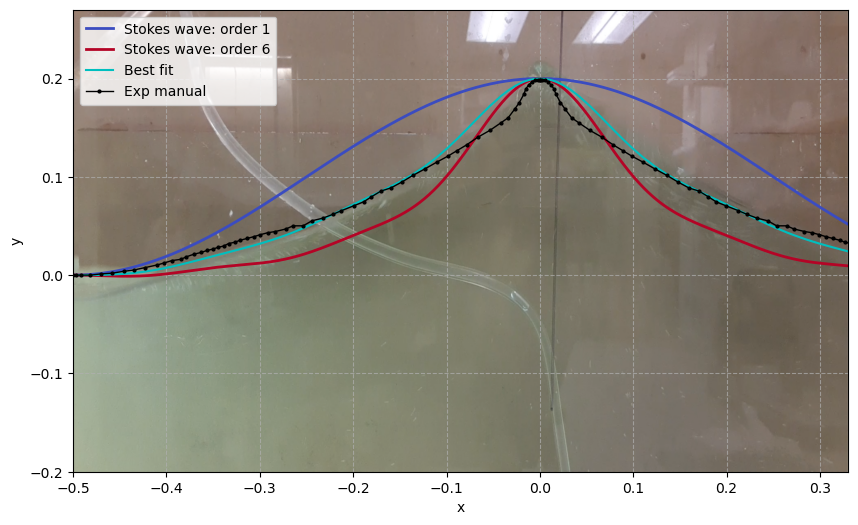

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load the uploaded image
image_path = 'initialCondition.png'
image = Image.open(image_path)

# Data points
x = [0, 0.0035714285714285713, 0.008928571428571428, 0.01845238095238095,
     0.030357142857142857, 0.04166666666666667, 0.05416666666666667, 0.06488095238095239,
     0.07738095238095238, 0.0898809523809524, 0.09702380952380953, 0.10595238095238095,
     0.11547619047619048, 0.12142857142857143, 0.12916666666666668, 0.13749999999999998,
     0.14345238095238097, 0.14940476190476193, 0.15535714285714286, 0.16130952380952382,
     0.16666666666666669, 0.17321428571428574, 0.17857142857142858, 0.1863095238095238,
     0.19404761904761905, 0.2005952380952381, 0.20833333333333334, 0.21666666666666667,
     0.22797619047619047, 0.23571428571428574, 0.24642857142857144, 0.255952380952381,
     0.26726190476190476, 0.2779761904761905, 0.28750000000000003, 0.30119047619047623,
     0.3113095238095238, 0.3196428571428572, 0.32976190476190476, 0.3404761904761905,
     0.35178571428571426, 0.36428571428571427, 0.3767857142857143, 0.3898809523809524,
     0.4011904761904762, 0.4113095238095238, 0.42142857142857143, 0.43333333333333335,
     0.44642857142857145, 0.4583333333333333, 0.46607142857142864, 0.4732142857142857,
     0.4779761904761905, 0.48273809523809524, 0.4851190476190476, 0.48809523809523814,
     0.4916666666666667, 0.49464285714285716, 0.4976190476190476, 0.5]

y = [0, 0, 0, 0,
     0.0012861736334405238, 0.001929260450160758, 0.003858520900321516, 0.00514469453376204,
     0.007717041800643087, 0.010289389067524135, 0.012218649517684893, 0.014790996784565913,
     0.01607717041800641, 0.018649517684887457, 0.021221864951768504, 0.023151125401929262,
     0.02508038585209002, 0.026366559485530544, 0.028295819935691302, 0.029581993569131826,
     0.032154340836012846, 0.03344051446945337, 0.035369774919614155, 0.03729903536977491,
     0.0392282958199357, 0.04115755627009646, 0.043086816720257215, 0.04437299035369774,
     0.046945337620578786, 0.05016077170418007, 0.05016077170418007, 0.05530546623794211,
     0.057877813504823156, 0.06173633440514467, 0.06559485530546624, 0.07073954983922828,
     0.07459807073954985, 0.0797427652733119, 0.0855305466237942, 0.08874598070739548,
     0.09453376205787781, 0.10160771704180063, 0.1080385852090032, 0.11511254019292602,
     0.12090032154340835, 0.12668810289389065, 0.13247588424437298, 0.14019292604501604,
     0.14726688102893887, 0.15498392282958195, 0.16012861736334405, 0.16913183279742763,
     0.1755627009646302, 0.18392282958199355, 0.18971061093247588, 0.1935691318327974,
     0.1967845659163987, 0.1980707395498392, 0.1980707395498392, 0.1980707395498392]

x = np.array(x, dtype=float)
y = np.array(y, dtype=float)

x = x-x[0]+EtaX[0]
y = y-y[0]

# After appending the flipped arrays
x = np.append(np.flip(-x), x)
y = np.append(np.flip(y), y)

# Sort by x
sorted_pairs = sorted(zip(x, y), key=lambda p: p[0])
x_sorted, y_sorted = zip(*sorted_pairs)
x, y = x_sorted, y_sorted

# Create the plot
plt.figure(figsize=(10, 6))

## theory stuff
EtaX = np.linspace(-0.5, 0.5, 1000)
a = 0.10  # amplitude (adjust this value)
k = 2*np.pi  # wave number (adjust this value)

if validate_stokes_parameters(k,a) is not True:
     print("Proceeding anyways, as this is only the initial condition")

OrderToPlot = [1,6] #np.arange(1, 11, 1)
# Create a color list from the colormap
COLORS = plt.cm.coolwarm(np.linspace(0, 1, len(OrderToPlot)))  # 3 colors for 3 orders

count = 0
for n in OrderToPlot:
     omega = dispersion_relation(k, g=9.81, order=n, a=a)
     if omega is not None:
          print("omega = ", omega)
     etaY = stokes_standing_wave(EtaX, 0., a, k, order=n)
     etaY = etaY - etaY[0]
     etaY = etaY/np.max(etaY)*0.2
     plt.plot(EtaX, etaY, '-', color=COLORS[count], linewidth=2, label=f'Stokes wave: order {n}')
     count += 1


etaY1 = stokes_standing_wave(EtaX, 0., a, k, order=1)
etaY2 = stokes_standing_wave(EtaX, 0., a, k, order=6)
etaY1 = etaY1 - etaY1[0]
etaY2 = etaY2 - etaY2[0]
etaY1 = etaY1/np.max(etaY1)*0.2
etaY2 = etaY2/np.max(etaY2)*0.2


# Interpolate etaY1, etaY2 to the experimental x grid
etaY1_interp = np.interp(x, EtaX, etaY1)
etaY2_interp = np.interp(x, EtaX, etaY2)

# We want to minimize sum((y - (wt*etaY1_interp + (1 - wt)*etaY2_interp))^2)
# Let Z = etaY1_interp - etaY2_interp and C = etaY2_interp,
# then etaYp = wt*Z + C.
Z = etaY1_interp - etaY2_interp
C = etaY2_interp

# The best wt satisfies d/dwt sum((y - (Z*wt + C))^2) = 0
# Leading to:
# wt = sum(Z*(y - C)) / sum(Z^2)
numerator = np.sum(Z*(y - C))
denominator = np.sum(Z**2)
wt_best = numerator/denominator

print("Best wt:", wt_best)

# Now you can re-plot etaYp with this optimized wt
etaYp_best = wt_best*etaY1_interp + (1 - wt_best)*etaY2_interp
plt.plot(x, etaYp_best, 'c-', label='Best fit')

plt.plot(x, y, 'k.-', linewidth=1, markersize=4, label='Exp manual')

# Overlay the image on the plot (adjust position and scaling manually)
image_extent = [-0.5, 0.33, -0.2, 0.27]  # [xmin, xmax, ymin, ymax] in data coordinates
plt.imshow(image, aspect='auto', extent=image_extent, alpha=1, origin='upper')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Show the plot
plt.show()

Stokes expansion may not converge
Proceeding anyways, as this is only the initial condition
omega =  7.850990247314777
omega =  13.354892631056417


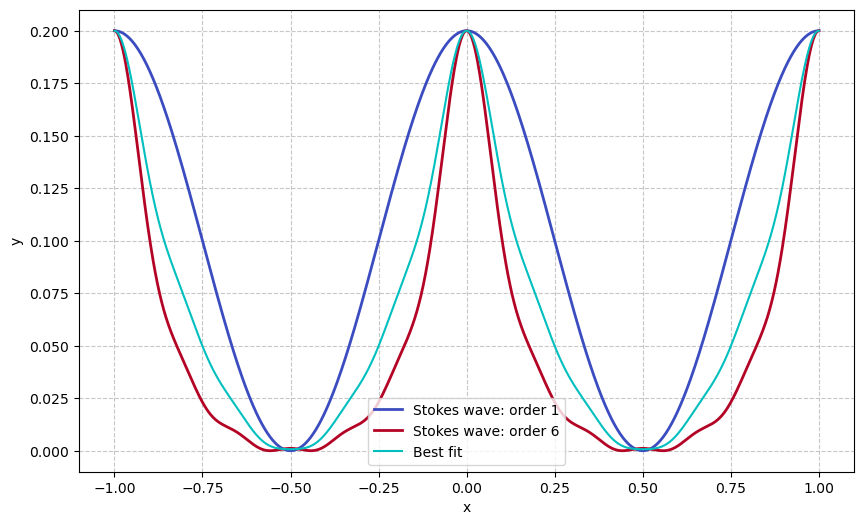

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
plt.figure(figsize=(10, 6))

## theory stuff
EtaX = np.linspace(-1.0, 1.0, 1000)
a = 0.10  # amplitude (adjust this value)
k = 2*np.pi  # wave number (adjust this value)

if validate_stokes_parameters(k,a) is not True:
     print("Proceeding anyways, as this is only the initial condition")

OrderToPlot = [1,6] #np.arange(1, 11, 1)
# Create a color list from the colormap
COLORS = plt.cm.coolwarm(np.linspace(0, 1, len(OrderToPlot)))  # 3 colors for 3 orders

count = 0
for n in OrderToPlot:
     omega = dispersion_relation(k, g=9.81, order=n, a=a)
     if omega is not None:
          print("omega = ", omega)
     etaY = stokes_standing_wave(EtaX, 0., a, k, order=n)
     etaY = etaY - np.min(etaY)
     etaY = etaY/np.max(etaY)*0.2
     plt.plot(EtaX, etaY, '-', color=COLORS[count], linewidth=2, label=f'Stokes wave: order {n}')
     count += 1


etaY1 = stokes_standing_wave(EtaX, 0., a, k, order=1)
etaY2 = stokes_standing_wave(EtaX, 0., a, k, order=6)
etaY1 = etaY1 - np.min(etaY1)
etaY2 = etaY2 - np.min(etaY2)
etaY1 = etaY1/np.max(etaY1)*0.2
etaY2 = etaY2/np.max(etaY2)*0.2


wt_best = 0.34749786297039387

# Now you can re-plot etaYp with this optimized wt
etaYp_best = wt_best*etaY1 + (1 - wt_best)*etaY2
plt.plot(EtaX, etaYp_best, 'c-', label='Best fit')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Show the plot
plt.show()

In [13]:
# Assuming EtaX and etaYp_best are numpy arrays
data_to_save = np.column_stack((EtaX, etaYp_best))

# Each line: two leading spaces, first number, three spaces, second number
# Using '%.7e' for seven digits after the decimal in scientific notation
fmt_str = '  %.7e   %.7e'

np.savetxt('expBestFit.dat', data_to_save, fmt=fmt_str, header='', comments='')